In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import json
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
#from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer , AutoModelForSequenceClassification, pipeline
#from datasets import Dataset

In [4]:
input = '/content/drive/MyDrive/fyp/fyp2/labelled data concat/full_labelled_data.csv'
unlabelled = "/content/drive/MyDrive/fyp/Bitcoin_tweets_cleaned_2.csv"
test2= '/content/drive/MyDrive/fyp/fyp2/amazon turk improved labels/valid-test result /concat/improved_amazon_concat_valid'
train2 = '/content/drive/MyDrive/fyp/fyp2/amazon turk improved labels/train result/concat/improved_amazon_concat_train.csv'
#model_name = "svalabs/twitter-xlm-roberta-bitcoin-sentiment"
model_name = "/content/-finetuned_self_trained-/checkpoint-99"
test_mode = True
unlabelled_size = 150000
self_label_training = True

full_v1 = pd.read_csv(input)
if test_mode:
  unlabelled = pd.read_csv(unlabelled,nrows = unlabelled_size)
else:
  unlabelled = pd.read_csv(unlabelled)

unlabelled = unlabelled.rename(columns={"tweet": "text"})

test_v2 = pd.read_csv(test2)
train_v2 = pd.read_csv(train2)
input = pd.read_csv(input)

display(unlabelled)
display(input)
display(train_v2)
display(test_v2)

,Unnamed: 0,date,text,is_retweet
0,0,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after bi...,False
1,1,2021-02-10 23:58:48,"😎 Today, that's this Thursday, we will do a ""🎬...",False
2,2,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",False
3,3,2021-02-10 23:54:33,51) Bitcoin FX BTC crypto,False
4,4,2021-02-10 23:54:06,BTC in too big to fail…,False
...,...,...,...,...
149995,150164,2021-06-23 06:18:18,linkedin twitter facebook instagram tiktok soc...,False
149996,150165,2021-06-23 06:18:16,freelance freelancer freelancing freelancers ...,False
149997,150166,2021-06-23 06:18:15,Judge blocks sale of Jay-Z's first album and i...,False
149998,150167,2021-06-23 06:18:06,"good project and strong team, in a predictable...",False


,Unnamed: 0,text,label
0,0,🔥🔥🔥 ANOTHER MASSIVE WIN! 🔥🔥🔥\n\nLUNA/USD Take-...,Positive
1,1,&gt;There is no inflation\n&gt;There is some i...,Neutral
2,2,China’s largest broadcaster’s NFT series becom...,Neutral
3,3,❗Bee Network-Cloud Mining on Your Phone ❗☁️⛏️💰...,Neutral
4,4,"Have you heard of $PIT, one of the largest com...",Positive
...,...,...,...
460,460,the strongest bullish signal flashed for Bitco...,Positive
461,461,the strongest bullish signal flashed for Bitco...,Positive
462,462,whre is the $dot whales\ndont miss these coins...,Positive
463,463,you are always talking about Bitcoin but MarkM...,Neutral


,text,label
0,\n\n Funds Increase Bitcoin $BTC Exposure\n R...,Neutral
1,"\n\n $39,309.32\n $1.186\n $389.10\n $0.8356\n...",Neutral
2,"\n\n BTC identified from CryptoMichNL's Tweet,...",Neutral
3,\n\nBTC ETH BNB SOL ADA \n\n $BTC $43140.45 (1...,Neutral
4,\n\nBTCMarkets\n $88748\n $841\n $5385\n $265\...,Neutral
...,...,...
1195,the strongest bullish signal flashed for Bitco...,Negative
1196,time to doge to dogecoin DogecoinToTheMoon bi...,spam
1197,we use bitcoin and mises to protect ourselves ...,Positive
1198,you are a decrept and your mind is linear. bi...,Neutral


,text,label
0,"\n55 PM . Apr 18,2022)\n\nBTC $40711.27\nETH ...",Neutral
1,NFTGiveway Coming Soon \n Sloths ...,Neutral
2,WOWOWOW SMH!\n\nBTC\nBitcoin ADA XRPArmy cryp...,Neutral
3,late night left 4 dead !\n\nLeft4Dead HIVE Tw...,Neutral
4,$CHZ\nAn unusual limit order (sell) added to t...,Neutral
...,...,...
185,bitcoin Is rejected from the trendline resista...,Positive
186,bitcoin btc\n\nWho put this thing togother? ME...,Neutral
187,blink and there is a new use case...adoption i...,Neutral
188,forests are burning in Turkey &amp; Greece. T...,Neutral


In [5]:
def ConvertLabel2ModelLabel(label):
  if label == 'Positive':
    o = 2
  elif label == 'Neutral':
    o = 1
  elif label == 'Negative':
    o = 0
  elif label == 'spam':
    o = 1
  else: 
    print(" error at ConvertLabel2ModelLabel label is " , label)
    o = np.nan
  return o

In [6]:
input['label'] = input['label'].apply(ConvertLabel2ModelLabel)
test_v2['label'] = test_v2['label'].apply(ConvertLabel2ModelLabel)
train_v2['label'] = train_v2['label'].apply(ConvertLabel2ModelLabel)

display(input)
display(test_v2)
display(train_v2)

,Unnamed: 0,text,label
0,0,🔥🔥🔥 ANOTHER MASSIVE WIN! 🔥🔥🔥\n\nLUNA/USD Take-...,2
1,1,&gt;There is no inflation\n&gt;There is some i...,1
2,2,China’s largest broadcaster’s NFT series becom...,1
3,3,❗Bee Network-Cloud Mining on Your Phone ❗☁️⛏️💰...,1
4,4,"Have you heard of $PIT, one of the largest com...",2
...,...,...,...
460,460,the strongest bullish signal flashed for Bitco...,2
461,461,the strongest bullish signal flashed for Bitco...,2
462,462,whre is the $dot whales\ndont miss these coins...,2
463,463,you are always talking about Bitcoin but MarkM...,1


,text,label
0,"\n55 PM . Apr 18,2022)\n\nBTC $40711.27\nETH ...",1
1,NFTGiveway Coming Soon \n Sloths ...,1
2,WOWOWOW SMH!\n\nBTC\nBitcoin ADA XRPArmy cryp...,1
3,late night left 4 dead !\n\nLeft4Dead HIVE Tw...,1
4,$CHZ\nAn unusual limit order (sell) added to t...,1
...,...,...
185,bitcoin Is rejected from the trendline resista...,2
186,bitcoin btc\n\nWho put this thing togother? ME...,1
187,blink and there is a new use case...adoption i...,1
188,forests are burning in Turkey &amp; Greece. T...,1


,text,label
0,\n\n Funds Increase Bitcoin $BTC Exposure\n R...,1
1,"\n\n $39,309.32\n $1.186\n $389.10\n $0.8356\n...",1
2,"\n\n BTC identified from CryptoMichNL's Tweet,...",1
3,\n\nBTC ETH BNB SOL ADA \n\n $BTC $43140.45 (1...,1
4,\n\nBTCMarkets\n $88748\n $841\n $5385\n $265\...,1
...,...,...
1195,the strongest bullish signal flashed for Bitco...,0
1196,time to doge to dogecoin DogecoinToTheMoon bi...,1
1197,we use bitcoin and mises to protect ourselves ...,2
1198,you are a decrept and your mind is linear. bi...,1


,text,label
0,🔥🔥🔥 ANOTHER MASSIVE WIN! 🔥🔥🔥\n\nLUNA/USD Take-...,2
1,&gt;There is no inflation\n&gt;There is some i...,1
2,China’s largest broadcaster’s NFT series becom...,1
3,❗Bee Network-Cloud Mining on Your Phone ❗☁️⛏️💰...,1
4,"Have you heard of $PIT, one of the largest com...",2
...,...,...
460,the strongest bullish signal flashed for Bitco...,2
461,the strongest bullish signal flashed for Bitco...,2
462,whre is the $dot whales\ndont miss these coins...,2
463,you are always talking about Bitcoin but MarkM...,1


23 9 60
Dataset({
    features: ['text', 'label'],
    num_rows: 1573
})
Dataset({
    features: ['text', 'label'],
    num_rows: 282
})


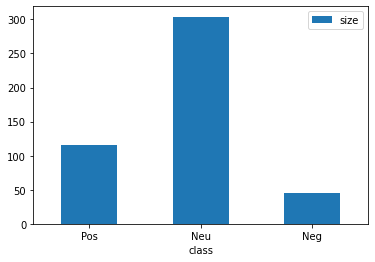

In [7]:
valid_percentage = 0.2



df = input.copy()
#valid_size_each_class = int(df.shape[0] * valid_percentage)


#print(valid_size_each_class)

sentences = df['text'].copy().to_list()
labels = []
urls = []



df = df[['text','label']]
display(df)


df_pos = df[df['label'] == 2].sample(frac=1).reset_index(drop=True)
df_neg = df[df['label'] == 0].sample(frac=1).reset_index(drop=True)
df_neu = df[df['label'] == 1].sample(frac=1).reset_index(drop=True)

#data = [10,20,30,40,50,60]

distri_class = pd.DataFrame({'class':['Pos', 'Neu', 'Neg'], 'size':[df_pos.shape[0], df_neu.shape[0], df_neg.shape[0]]})
ax = distri_class.plot.bar(x='class', y='size', rot=0)

valid_size_class_pos = int(df_pos.shape[0] * valid_percentage)
valid_size_class_neg = int(df_neg.shape[0] * valid_percentage)
valid_size_class_neu = int(df_neu.shape[0] * valid_percentage)

print(valid_size_class_pos,valid_size_class_neg,valid_size_class_neu)

validation_dataset = df_pos[0:valid_size_class_pos]
validation_dataset = validation_dataset.append(df_neg[0:valid_size_class_neg])
validation_dataset = validation_dataset.append(df_neu[0:valid_size_class_neu])
validation_dataset = validation_dataset.append(test_v2)
validation_dataset = validation_dataset.sample(frac=1).reset_index(drop=True)


training_dataset = df_pos[valid_size_class_pos:]
training_dataset = training_dataset.append(df_neg[valid_size_class_neg:])
training_dataset = training_dataset.append(df_neu[valid_size_class_neu:])
training_dataset = training_dataset.append(train_v2)
training_dataset = training_dataset.sample(frac=1).reset_index(drop=True)

#if hyperparameter_tuning :
 # training_dataset = training_dataset[0:200]


dataset = ds.dataset(pa.Table.from_pandas(validation_dataset).to_batches())
### convert to Huggingface dataset
validation_dataset_torch = Dataset(pa.Table.from_pandas(validation_dataset))

dataset = ds.dataset(pa.Table.from_pandas(training_dataset).to_batches())
### convert to Huggingface dataset
training_dataset_torch = Dataset(pa.Table.from_pandas(training_dataset))

print(training_dataset_torch)
print(validation_dataset_torch)

In [8]:
import datasets
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm


def labelling(df,model_name):
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name)
  pipe = pipeline("sentiment-analysis", model = model, tokenizer = tokenizer,device=0)
  dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())
    ### convert to Huggingface dataset
  dataset_hug = Dataset(pa.Table.from_pandas(df))


  label = []
  conf = []
  for res in tqdm(pipe(KeyDataset(dataset_hug, "text"))):
    #res = classifier(text)[0]
    label_text = res['label']
    if label_text == 'Positive':
      label_num = 2
    elif label_text == 'Negative':
      label_num = 0
    else:
      label_num = 1

    label.append(label_num)
    conf.append(res['score'])

  df['conf'] = conf
  df['label'] = label
  return df

if self_label_training:
  self_labelled = unlabelled[['text']].copy()
  self_labelled = labelling(self_labelled,model_name)
  #display(self_labelled)
  display(self_labelled)

  training_dataset_with_self_labelled = training_dataset.append(self_labelled[['text','label']])

  display(training_dataset_with_self_labelled)

  dataset = ds.dataset(pa.Table.from_pandas(training_dataset_with_self_labelled).to_batches())
  ### convert to Huggingface dataset
  training_dataset_torch_with_self_labelled = Dataset(pa.Table.from_pandas(training_dataset_with_self_labelled))



  0%|          | 0/150000 [00:00<?, ?it/s]

,text,conf,label
0,Blue Ridge Bank shares halted by NYSE after bi...,0.754261,0
1,"😎 Today, that's this Thursday, we will do a ""🎬...",0.999491,1
2,"Guys evening, I have read this article about B...",0.977192,1
3,51) Bitcoin FX BTC crypto,0.987833,1
4,BTC in too big to fail…,0.999948,0
...,...,...,...
149995,linkedin twitter facebook instagram tiktok soc...,0.891641,1
149996,freelance freelancer freelancing freelancers ...,0.999072,1
149997,Judge blocks sale of Jay-Z's first album and i...,0.500692,2
149998,"good project and strong team, in a predictable...",0.996910,2


,text,label
0,good project YieldFarming Airdrop Binance...,2
1,_io _io is the best project recent time. Mos...,2
2,Good project FLAG FlagNetwork IDO cryptocurre...,2
3,Good news coming ? bitcoin ? Volcano mining ?,2
4,People mocking _saylor now reminds me a lot of...,2
...,...,...
149995,linkedin twitter facebook instagram tiktok soc...,1
149996,freelance freelancer freelancing freelancers ...,1
149997,Judge blocks sale of Jay-Z's first album and i...,2
149998,"good project and strong team, in a predictable...",2


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name,model_max_length=512)


def tokenize_function(data):
    return tokenizer(data['text'], padding="max_length", truncation=True,)

print(type(training_dataset_torch))

if self_label_training:
  train_dataset = training_dataset_torch_with_self_labelled.map(tokenize_function, batched=True)
else:
  train_dataset = training_dataset_torch.map(tokenize_function, batched=True)
eval_dataset = validation_dataset_torch.map(tokenize_function, batched=True)
print(train_dataset)
print(eval_dataset)

<class 'datasets.arrow_dataset.Dataset'>


  0%|          | 0/152 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 151573
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 282
})


In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("matthews_correlation")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import AutoModelForSequenceClassification


#model.to(device)

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
#learning_rate = 5e-05
batch_size = 16
#eval_batch_size = 4
seed = 40
#optimizer = Adam 
#with betas=(0.9,0.999) and epsilon=1e-08
adam_beta1 = 0.9
adam_beta2 =0.999
lr_scheduler_type = "linear"
num_epochs = 15
#args = TrainingArguments("test_trainer",report_to="wandb" ,logging_strategy = "epoch",evaluation_strategy="epoch",learning_rate = learning_rate,num_train_epochs = num_epochs,lr_scheduler_type =lr_scheduler_type, adam_beta1 = adam_beta1,adam_beta2 =adam_beta2  )



#model_name = "/content/-finetuned_self_trained-/checkpoint-99"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

args = TrainingArguments(
    #'/content/drive/MyDrive/fyp/fyp2/model/model2-supervised/' + f"{model_name}-finetuned-",
    '/content/' + "-finetuned_self_trained-v2",
    #report_to="wandb",
    overwrite_output_dir = True,
    evaluation_strategy = "epoch",
    logging_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4.5682e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    metric_for_best_model='matthews_correlation',
    save_total_limit = 2,
    #save_strategy = "epoch",
    load_best_model_at_end = True,
    seed = 40,
    #push_to_hub=True,
)


trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#trainer = Trainer(
   # model=model,
    #args=args,
   # train_dataset=train_dataset,
  #  eval_dataset=eval_dataset,
 #   compute_metrics=compute_metrics,
#)
hyperparameter_tuning = False
if hyperparameter_tuning == False:
  trainer.train()
  trainer.evaluate()